In [1]:
import delfi.distribution as dd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

import scipy as sp

#from delfi.inference import Basic, CDELFI
from CDELFI import CDELFI
from delfi.generator import Default
from delfi.utils.viz import probs2contours
from util import *
from sim_gauss import *
from sumstat_mean import *

import pickle

from parameters import ParameterSet

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
params = ParameterSet({})

params.ndim = 2  # dimensionality of problem
params.n_comps = 5  # number of components

params.x_width = 4

params.dof = params.ndim
params.scale = 1
params.alpha = 1

params.prior_width = 5
params.prop_width = 1

In [3]:
target_a = np.random.dirichlet(params.alpha * np.ones(params.n_comps))
target_mus = np.random.uniform(-params.x_width, params.x_width, size=(params.n_comps, params.ndim))

target_Sgen = sp.stats.invwishart(df=params.dof, scale=params.scale * np.eye(params.ndim))
target_Ss = target_Sgen.rvs(size=params.n_comps)

params.target = dd.MoG(target_a, target_mus, target_Ss)
params.prior = dd.Gaussian(m=np.zeros(params.ndim), S=params.prior_width * np.eye(params.ndim))
params.prop = dd.Gaussian(m=np.zeros(params.ndim), S=params.prop_width * np.eye(params.ndim))
params.uncorrected = params.target * params.prop / params.prior

In [4]:
def print_pdf(pdf, name):
    po = np.get_printoptions()
    np.set_printoptions(precision=2)
    print("{}:".format(name))
    print("----------------")
    print("Mixture weights: {}".format(pdf.a))
    print("Means:")
    for x in pdf.xs:
        print("{}".format(x.m))
    print()
    print("Covariances:")
    for x in pdf.xs:
        print("{}".format(x.S))
    print()
    np.set_printoptions(**po)

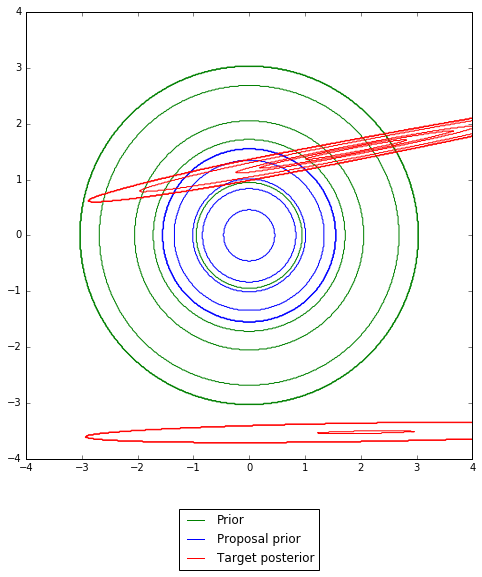

Target distribution:
----------------
Mixture weights: [ 0.11  0.54  0.29  0.03  0.03]
Means:
[ 2.12 -3.53]
[ 1.93  1.54]
[-0.25  2.59]
[-3.03  2.26]
[-1.02 -1.06]

Covariances:
[[ 9.39  0.15]
 [ 0.15  0.01]]
[[ 2.63  0.5 ]
 [ 0.5   0.1 ]]
[[ 3.4   1.18]
 [ 1.18  6.11]]
[[ 8.73 -2.92]
 [-2.92  2.19]]
[[  4.96  -3.27]
 [ -3.27  12.94]]



In [5]:
# visualize results
res = 500
xlims = (-params.x_width, params.x_width)
ylims = xlims

xaxis = np.linspace(*xlims, res)
yaxis = np.linspace(*ylims, res)
x, y = np.meshgrid(xaxis, yaxis)

xy = np.concatenate([x.reshape([-1, 1]), 
                     y.reshape([-1, 1])], 
                    axis=1)


levels = [0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

prior_contour = probs2contours(params.prior.eval(xy, log=False), levels).reshape(res, res)
prop_contour = probs2contours(params.prop.eval(xy, log=False), levels).reshape(res, res)
target_contour = probs2contours(params.target.eval(xy, log=False), levels).reshape(res, res)

plt.figure(figsize=(8, 8))

plt.contour(x, y, prior_contour, colors=('g'))
plt.contour(x, y, prop_contour, colors=('b'))
plt.contour(x, y, target_contour, colors=('r'))

green_line = mlines.Line2D([], [], color='g', label='Prior')
blue_line = mlines.Line2D([], [], color='b', label='Proposal prior')
red_line = mlines.Line2D([], [], color='r', label='Target posterior')
plt.legend(handles=[green_line, blue_line, red_line], 
           loc=9, bbox_to_anchor=(0.5, -0.1))

plt.show()

print_pdf(params.target, 'Target distribution')

In [6]:
pickle.dump(params, open('example_mog.pkl', 'wb'))